In [ ]:
# This script runs a multivariate cox proportional hazard model w/ clinical features and protein expression to assess laryngeal cancer patient survival
# Feature contribution is visualized with nomogram-style plots and SHAP plots
# Patients are stratified into High and low Risk groups based on median risk score cutoff generated by Cox PH linear predictor.
# Survival probability is determined via Kaplan-Meier method w/ log-rank testing to compare survival curves of high and low risk patients
# Scatter plots are used to visualize individual patients by risk score and feature values.
# Table with patient IDs, feature values, risk score, and risk category is created and saved.


<lifelines.CoxPHFitter: fitted with 49 total observations, 18 right-censored observations>
             duration col = 'OS_Months'
                event col = 'OS_Status'
      baseline estimation = breslow
   number of observations = 49
number of events observed = 31
   partial log-likelihood = -93.75
         time fit was run = 2025-09-12 22:27:16 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
Age       -0.04      0.96      0.03           -0.10            0.01                0.91                1.01
Race       0.45      1.57      0.42           -0.38            1.28                0.68                3.61
Treatment -1.14      0.32      0.51           -2.13           -0.14                0.12                0.87
Sex        0.66      1.93      0.68           -0.68            1.99                0.51                7.30
ABCC1     -0.34      0.71      0.41           -1.15            0.47                0.32                1.60
Grade      1.79      5.98      1.06           -0.28            3.86                0.75               47.44

           cmp to     z    p  -log2(p)
covariate                             
Age          0.00 -1.56 0.12      3.08
Race         0.00  1.07 0.29      1.81
Treatment    0.00 -2.24 0.03      5.32
Sex          0.00  0.97 0.33      1.58
ABCC1        0.00 -0.82 0.41      1.28
Grade        0.00  1.69 0.09      3.46
---
Concordance = 0.71
Partial AIC = 199.50
log-likelihood ratio test = 12.84 on 6 df
-log2(p) of ll-ratio test = 4.45

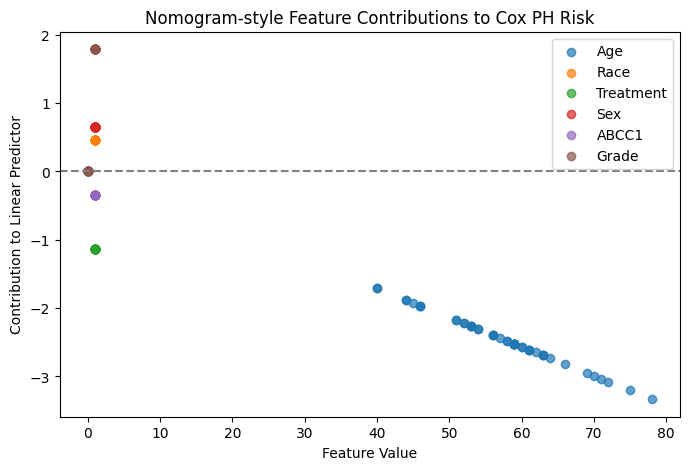

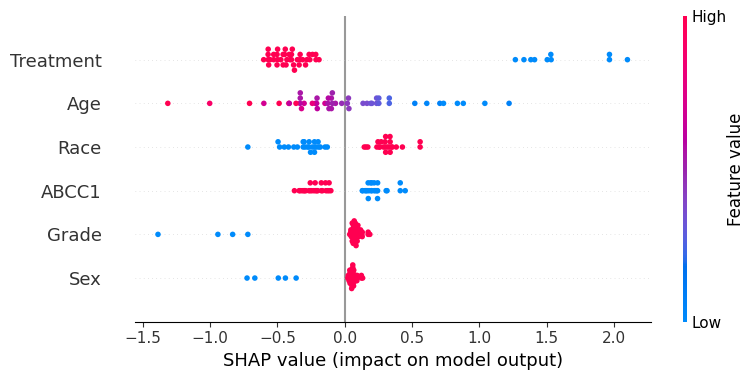

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
RiskGroup  0.947178   2.578424  0.374116        0.213925        1.680431   

           exp(coef) lower 95%  exp(coef) upper 95%  cmp to        z  \
covariate                                                              
RiskGroup              1.23853              5.36787     0.0  2.53178   

                  p  -log2(p)  
covariate                      
RiskGroup  0.011349  6.461352  
Risk score cutoff (median): 1.1727


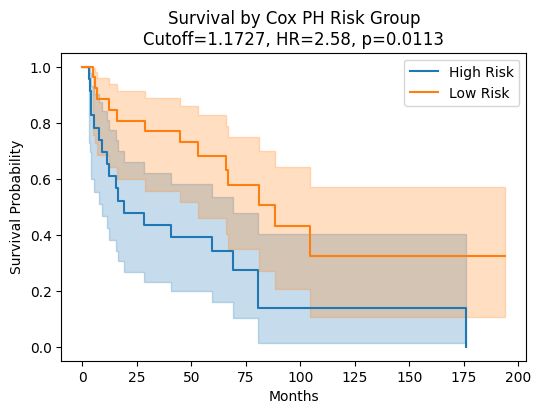

Median risk score cutoff: 1.1727
Hazard Ratio (High vs Low): 2.58
95% CI: [1.2385300675676005, 5.367869622502049]
p-value: 1.1349e-02


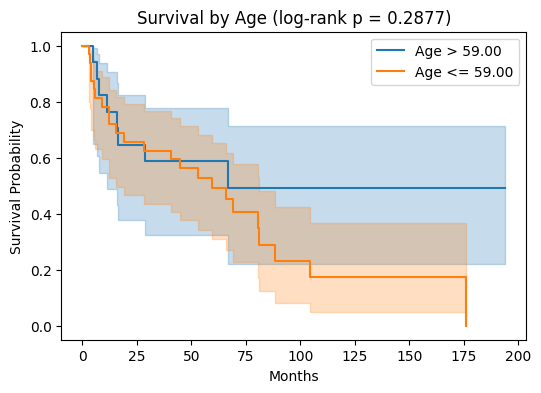

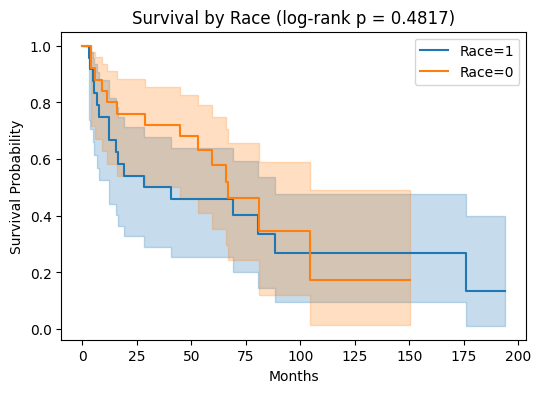

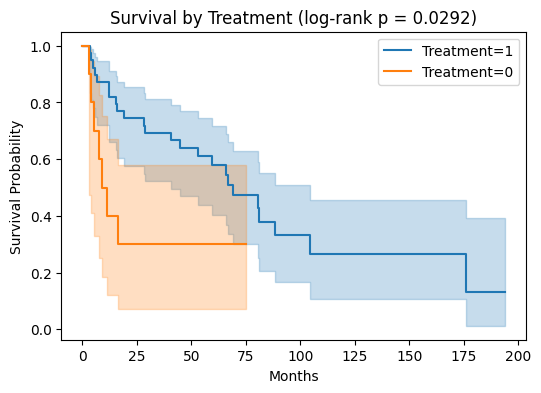

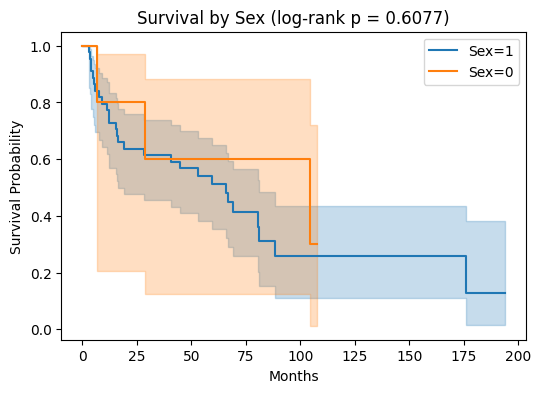

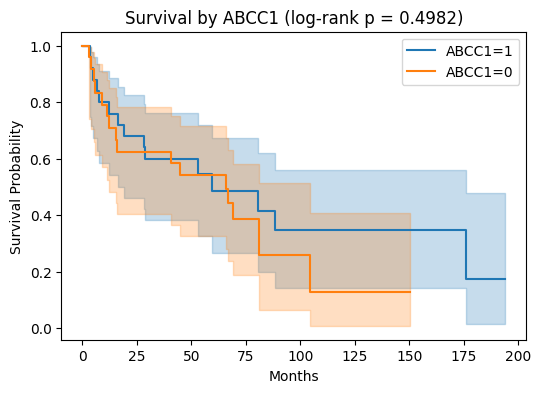

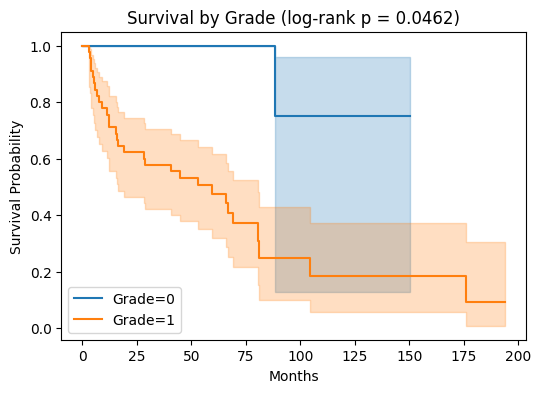

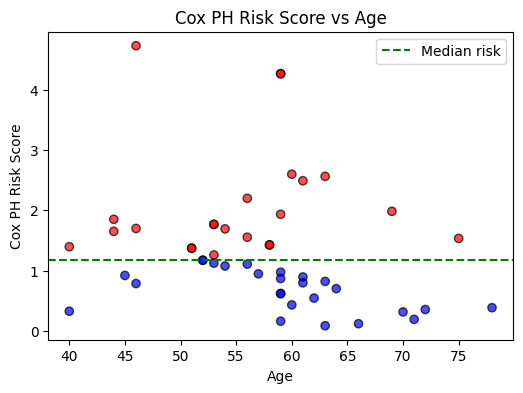

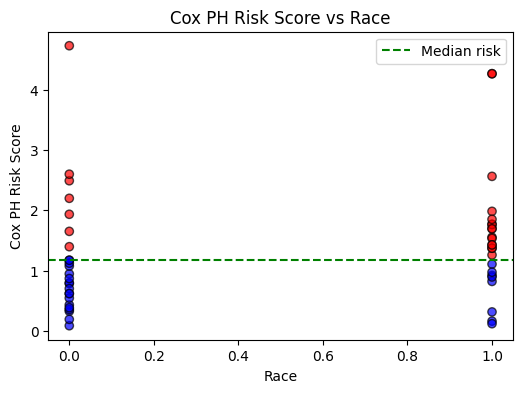

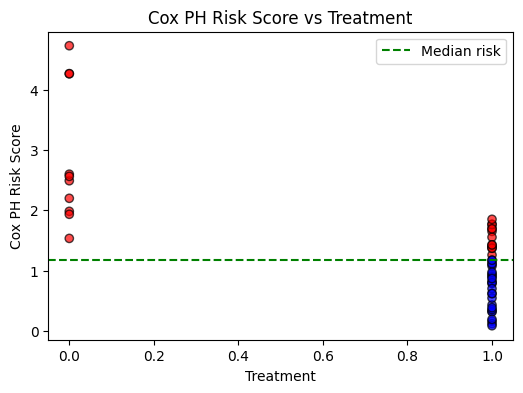

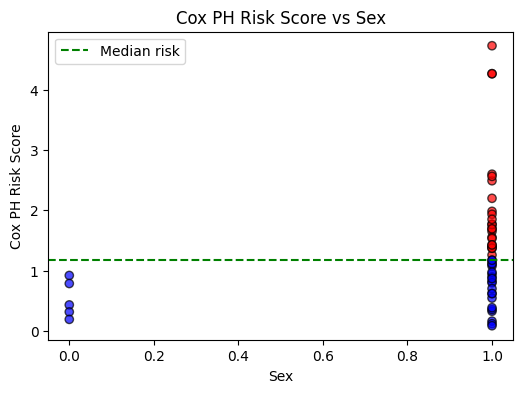

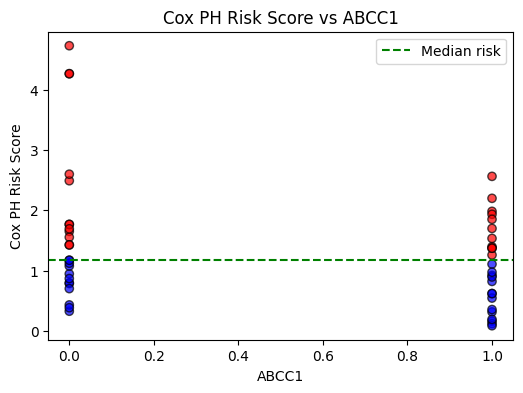

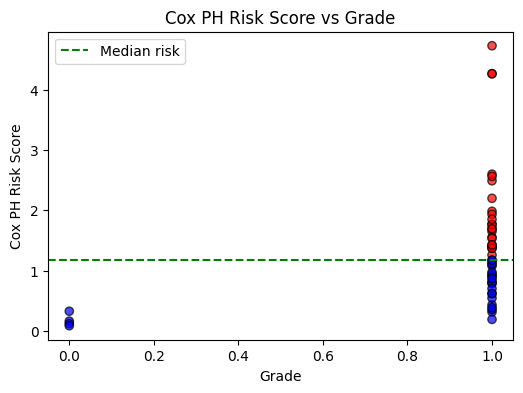

In [10]:
# Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
import shap

# Load data
file_path = "Epic_Surv_Predictors_51PTS.csv"
df = pd.read_csv(file_path)

# Feature engineering
feature_cols = ['Age', 'Race', 'Treatment', 'Sex', 'ABCC1', 'Grade']  #  variable binarization performed beforehand
duration_col = 'OS_Months'
event_col = 'OS_Status'
id_col = 'MRN'  # patient identifier

# Replace blanks with NaN and drop missing
df[feature_cols] = df[feature_cols].replace(r'^\s*$', np.nan, regex=True)
df = df.dropna(subset=feature_cols + [duration_col, event_col])

# Convert features to appropriate types
df['Age'] = df['Age'].astype(float) #continuous variable

for col in ['Race', 'Treatment', 'Sex', 'ABCC1', 'Grade']:
    df[col] = df[col].astype(int)  # binary variables

# Fit multivariate Cox model
cph = CoxPHFitter()
cph.fit(df[[duration_col, event_col] + feature_cols], duration_col=duration_col, event_col=event_col)
cph.print_summary()  # HR, CI, p-values

# Calculate patient-level risk scores
df['Cox_RiskScore'] = cph.predict_partial_hazard(df[feature_cols])
df['HighRisk'] = df['Cox_RiskScore'] > df['Cox_RiskScore'].median()

# Nomogram-style plot of feature contributions
coef = cph.params_.loc[feature_cols]

plt.figure(figsize=(8,5))
for i, feat in enumerate(feature_cols):
    contrib = df[feat] * coef[feat]
    plt.scatter(df[feat], contrib, label=feat, alpha=0.7)
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel("Feature Value")
plt.ylabel("Contribution to Linear Predictor")
plt.title("Nomogram-style Feature Contributions to Cox PH Risk")
plt.legend()
plt.show()

# SHAP summary plot: ranks feature importance
# Use the linear predictor (log risk score- partial hazard) approximation
explainer = shap.Explainer(lambda x: cph.predict_partial_hazard(pd.DataFrame(x, columns=feature_cols)), df[feature_cols])
shap_values = explainer(df[feature_cols])

# Beeswarm dot plot (shows direction: color = feature value)
shap.summary_plot(shap_values.values, df[feature_cols], feature_names=feature_cols, plot_type="dot")

# Stratifying patients into low and high risk groups
median_risk = df['Cox_RiskScore'].median()
df['RiskGroup'] = np.where(df['Cox_RiskScore'] > median_risk, 1, 0)

# Fit a Cox model with only RiskGroup
hr_cph = CoxPHFitter()
hr_cph.fit(df[[duration_col, event_col, 'RiskGroup']], duration_col=duration_col, event_col=event_col)
print(hr_cph.summary)

print(f"Risk score cutoff (median): {median_risk:.4f}")

# KM plots stratified by Cox PH risk score (shows Risk cutoff, HR and log-rank p-value)
hr = np.exp(hr_cph.params_['RiskGroup'])
p_val = hr_cph.summary.loc['RiskGroup', 'p']

kmf = KaplanMeierFitter()
median_risk = df['Cox_RiskScore'].median()
high_risk_mask = df['Cox_RiskScore'] > median_risk
low_risk_mask = df['Cox_RiskScore'] <= median_risk

# Log-rank test to compare survival curves
results = logrank_test(df[duration_col][high_risk_mask], df[duration_col][low_risk_mask],
                       event_observed_A=df[event_col][high_risk_mask],
                       event_observed_B=df[event_col][low_risk_mask])
p_value = results.p_value

plt.figure(figsize=(6,4))
kmf.fit(df[duration_col][high_risk_mask], event_observed=df[event_col][high_risk_mask], label='High Risk')
kmf.plot_survival_function()
kmf.fit(df[duration_col][low_risk_mask], event_observed=df[event_col][low_risk_mask], label='Low Risk')
kmf.plot_survival_function()
#plt.title(f'Survival by Cox PH Predicted Risk\nMedian split, log-rank p = {p_value:.4f}')
plt.title(f'Survival by Cox PH Risk Group\nCutoff={median_risk:.4f}, HR={hr:.2f}, p={p_val:.4f}')
plt.xlabel('Months')
plt.ylabel('Survival Probability')
plt.show()

print(f"Median risk score cutoff: {median_risk:.4f}")
print(f"Hazard Ratio (High vs Low): {hr:.2f}")
print(f"95% CI: {np.exp(hr_cph.confidence_intervals_).loc['RiskGroup'].tolist()}")
print(f"p-value: {p_val:.4e}")

# KM plots for individual features (shows log-rank p-values)
for feat in feature_cols:
    plt.figure(figsize=(6,4))
    
    if df[feat].nunique() > 2:  # continuous: split by median
        median_val = df[feat].median()
        high_mask = df[feat] > median_val
        low_mask = df[feat] <= median_val
        kmf.fit(df[duration_col][high_mask], event_observed=df[event_col][high_mask], label=f'{feat} > {median_val:.2f}')
        kmf.plot_survival_function()
        kmf.fit(df[duration_col][low_mask], event_observed=df[event_col][low_mask], label=f'{feat} <= {median_val:.2f}')
        kmf.plot_survival_function()
        
# log-rank test
        results = logrank_test(df[duration_col][high_mask], df[duration_col][low_mask],
                               event_observed_A=df[event_col][high_mask],
                               event_observed_B=df[event_col][low_mask])
        p_val = results.p_value
        plt.title(f'Survival by {feat} (log-rank p = {p_val:.4f})')
    else:  # binary feature
        masks = [df[feat]==val for val in df[feat].unique()]
        labels = [f'{feat}={val}' for val in df[feat].unique()]
        for msk, lbl in zip(masks, labels):
            kmf.fit(df[duration_col][msk], event_observed=df[event_col][msk], label=lbl)
            kmf.plot_survival_function()
        
# log-rank test for two binary groups
        if df[feat].nunique() == 2:
            val0, val1 = df[feat].unique()
            mask0 = df[feat]==val0
            mask1 = df[feat]==val1
            results = logrank_test(df[duration_col][mask0], df[duration_col][mask1],
                                   event_observed_A=df[event_col][mask0],
                                   event_observed_B=df[event_col][mask1])
            p_val = results.p_value
            plt.title(f'Survival by {feat} (log-rank p = {p_val:.4f})')
        else:
            plt.title(f'Survival by {feat}')
    
    plt.xlabel('Months')
    plt.ylabel('Survival Probability')
    plt.show()

# Scatter plots: Cox PH risk score vs each feature
for feat in feature_cols:
    plt.figure(figsize=(6,4))
    plt.scatter(df[feat], df['Cox_RiskScore'], c=df['HighRisk'], cmap='bwr', edgecolor='k', alpha=0.7)
    plt.axhline(df['Cox_RiskScore'].median(), color='green', linestyle='--', label='Median risk')
    plt.xlabel(feat)
    plt.ylabel('Cox PH Risk Score')
    plt.title(f'Cox PH Risk Score vs {feat}')
    plt.legend()
    plt.show()

# Create table of patient risk scores including MRN
risk_table = df[[id_col, 'Cox_RiskScore', 'HighRisk'] + feature_cols]
risk_table.to_csv("CoxPH_Patient_RiskScores_with_MRN.csv", index=False)